In [1]:
import pandas as pd
import basicdescriptives_mod as bd
import re
import string
import spacy
import nltk

from nltk.stem import SnowballStemmer
nlp = spacy.load("es_core_news_md")

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
from sklearn.cluster import KMeans


In [145]:
#!pip install umap-learn==0.5.2

In [163]:
df = pd.read_csv('../data/stage/db_stage_infousers.csv')

In [3]:
bd.info(df)

Number of Columns: 23
Number of total rows: 4113
Number of Unique Rows: 4113


,Column Name,Data Type,Non null values,Unique Values
0,PLAZO,int64,4113,27
1,CAPITAL,int64,4113,58
2,DÍAS MORA,int64,4113,1610
3,Cuotas en mora,int64,4113,2
4,ESTRATO,float64,4105,7
5,INGRESOS MENSUALES,float64,3424,724
6,GASTOS MENSUALES,float64,3404,188
7,INGRESOS ADICIONALES,float64,2336,164
8,PERSONAS A CARGO,float64,2749,6
9,NUMERO DE HIJOS,float64,2744,6


In [4]:
df['TRABAJO'].value_counts().head(30)

TRABAJO
Guarda de seguridad        55
Docente                    54
Operario                   45
Asesor comercial           39
Asesor                     38
docente                    35
Conductor                  33
asesor comercial           31
guarda de seguridad        26
Propietario                24
auxiliar administrativo    24
Analista                   23
Administrador              22
Auxiliar administrativo    21
Supervisor                 19
Vigilante                  18
Gerente                    17
administrador              17
Dueño                      17
conductor                  16
Guarda de seguridad        16
operario                   16
AUXILIAR CONTABLE          15
auxiliar contable          15
propietario                14
Auxiliar Administrativo    14
supervisor                 13
ASISTENTE CONTABLE         13
Auxiliar                   12
Asesor comercial           12
Name: count, dtype: int64

In [6]:
def procesing_text(texto):
    ### Limpieza
    texto = texto.lower() # Estandarizar todo a minúscula
    texto = re.sub('[%s]' % re.escape(string.punctuation), ' ', texto) # Eliminar puntuación
    texto = re.sub(r"\w*\d+\w*", '', texto) # Eliminar dígitos y palabras con dígitos
    #texto = re.sub(r'\b\w*[^a-zA-Z\s]+\w*\b|[^\w\s]+', '', texto) # Eliminar caracteres especiales y palabras con estos
    texto = re.sub(r'\s+', ' ', texto) # Eliminar espacios en blanco adicionales
    texto = re.sub(r'\b\w\b', '', texto) # Eliminar palabras de un solo caracter
    
    ### Tokenizacion
    tokens = nlp (texto)
    filtered_tokens = [token for token in tokens if not token.is_stop]
    ### Lemmatizing
    lemmatized_tokens = [token.lemma_ for token in filtered_tokens]
    ### Steaming
    stemmer = SnowballStemmer("spanish")
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    

    return " ".join(stemmed_tokens)

In [8]:
texto = ' Auxiliar administrativo y administrador'
procesing_text(texto)

'  auxili administr   administr'

In [9]:
df['TRABAJO'] = df['TRABAJO'].apply(lambda x: str(x))

In [10]:
df['Trabajo1'] = df['TRABAJO'].apply(procesing_text)

In [11]:
df['Trabajo1'].nunique()

1489

In [12]:
df['Trab_tokens'] = df['Trabajo1'].apply(nltk.word_tokenize)

In [13]:
dictionary = Dictionary(df.Trab_tokens)

corpus = [dictionary.doc2bow(doc) for doc in df.Trab_tokens]

In [14]:
procesing_text(df['Trabajo1'][0])

'despach bodeg'

In [15]:
lda_model = LdaModel(corpus = corpus, num_topics=50, id2word=dictionary, passes=10)

In [16]:
def assigntopic(doc):
    vector = lda_model[dictionary.doc2bow(doc)]
    #vector = sorted(vector, key=lambda item: -item[1])
    vector = max(vector, key=lambda item: -item[1])
    return vector[0]

In [17]:
df['topicos'] = df.Trab_tokens.apply(assigntopic)

In [18]:
df.head(30)

,PLAZO,CAPITAL,DÍAS MORA,Cuotas en mora,ESTRATO,INGRESOS MENSUALES,GASTOS MENSUALES,INGRESOS ADICIONALES,PERSONAS A CARGO,NUMERO DE HIJOS,...,AÑOS EN LA VIVIENDA,TIPO DE CONTRATO,PERIODO DE PAGO,ESTADO CIVIL,NIVEL EDUCATIVO,TIPO DE VEHICULO,TIEMPO TRABAJO,Trabajo1,Trab_tokens,topicos
0,9,100000,2869,1,2.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,Indefinido,Mensual,NaN,NaN,Ninguno,24 meses,despach bodeg,"[despach, bodeg]",0
1,14,150000,2864,1,3.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,Indefinido,Mensual,NaN,NaN,Ninguno,12 meses,supervisor,[supervisor],0
2,30,350000,2856,1,3.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,Termino fijo,Mensual,NaN,NaN,Carro,1 año,psicolog,[psicolog],0
3,29,250000,2851,1,3.0,NaN,NaN,NaN,1.0,1.0,...,entre uno y cinco años,NaN,NaN,NaN,NaN,Ninguno,NaN,rentist capital,"[rentist, capital]",0
4,28,200000,2851,1,3.0,NaN,NaN,NaN,1.0,1.0,...,entre uno y cinco años,Termino fijo,Mensual,NaN,NaN,Ninguno,9 horas,docent infanci,"[docent, infanci]",0
5,30,150000,2850,1,3.0,NaN,NaN,NaN,1.0,1.0,...,mas de 5 años,Termino fijo,Quincenal,NaN,NaN,Carro,3 años,oper divis,"[oper, divis]",0
6,30,100000,2850,1,3.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,NaN,NaN,NaN,NaN,Ninguno,NaN,jef,[jef],0
7,21,100000,2849,1,2.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,Indefinido,Quincenal,NaN,NaN,Ninguno,3 meses,ensambl,[ensambl],0
8,29,150000,2844,1,3.0,NaN,NaN,NaN,2.0,2.0,...,mas de 5 años,Indefinido,Mensual,NaN,NaN,Moto,1 AÑO,tecnic,[tecnic],0
9,30,150000,2843,1,2.0,NaN,NaN,NaN,0.0,0.0,...,mas de 5 años,NaN,NaN,NaN,NaN,Ninguno,NaN,nan,[nan],0


## con embedings


In [19]:
def get_embedings(texto):
    return nlp(texto).vector

In [20]:
df['embeddings'] = df['TRABAJO'].apply(get_embedings)

In [21]:
import numpy as np
X = np.array([x.tolist() for x in df['embeddings']])

# Especifica el número de clusters que deseas
n_clusters = 20

# Crea una instancia de KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Realiza la clusterización
clusters = kmeans.fit_predict(X)

df['cluster'] = clusters

c:\Users\jgome\anaconda3\envs\DataScience\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## cluster con vectores


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is is a sample text', 'Another example']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [23]:
vectorizer = CountVectorizer(max_features=10000)
matriz_frecuencia = vectorizer.fit_transform(df['Trabajo1'])
vocabulary = vectorizer.vocabulary_

In [24]:
df['text_vec'] = [matriz_frecuencia.getrow(i).toarray()[0] for i in range(len(df))]

In [25]:
df[['TRABAJO','Trabajo1','text_vec']].head()

,TRABAJO,Trabajo1,text_vec
0,despachador de bodega,despach bodeg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,supervisor,supervisor,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Psicologa,psicolog,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,rentista capital,rentist capital,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Docente primera infancia,docent infanci,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
import numpy as np
X = np.array([x.tolist() for x in df['text_vec']])

# Especifica el número de clusters que deseas
n_clusters = 20

# Crea una instancia de KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Realiza la clusterización
clusters = kmeans.fit_predict(X)

df['cluster2'] = clusters

c:\Users\jgome\anaconda3\envs\DataScience\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [27]:
df[['TRABAJO','Trabajo1','cluster','cluster2']].head(50)

,TRABAJO,Trabajo1,cluster,cluster2
0,despachador de bodega,despach bodeg,5,9
1,supervisor,supervisor,14,18
2,Psicologa,psicolog,7,17
3,rentista capital,rentist capital,14,17
4,Docente primera infancia,docent infanci,14,1
5,Operador de divisas,oper divis,5,10
6,jefe,jef,8,17
7,ensamblador,ensambl,14,17
8,TECNICO,tecnic,4,8
9,nan,nan,2,16


In [28]:
all_text = ' '.join(df['Trabajo1'])
tokens = nltk.word_tokenize(all_text)

# Calcular la frecuencia de los términos
fdist = nltk.FreqDist(tokens)

# Mostrar los términos más comunes y su frecuencia
print(fdist.most_common())

[('auxili', 532), ('asesor', 309), ('administr', 306), ('comercial', 194), ('anal', 186), ('asistent', 175), ('segur', 149), ('oper', 142), ('operari', 139), ('tecnic', 136), ('guard', 128), ('docent', 124), ('coordin', 106), ('contabl', 104), ('nan', 102), ('jef', 89), ('servici', 88), ('supervisor', 77), ('conductor', 74), ('aux', 67), ('propietari', 67), ('ejecut', 63), ('vent', 60), ('secretari', 57), ('gerent', 56), ('profesional', 55), ('sistem', 50), ('dueñ', 49), ('vendedor', 48), ('director', 47), ('logist', 43), ('bodeg', 39), ('contrat', 39), ('vigil', 39), ('factur', 38), ('lid', 38), ('agent', 37), ('produccion', 36), ('general', 34), ('ingenier', 34), ('gestor', 33), ('contador', 32), ('enfermer', 32), ('cajer', 31), ('cent', 30), ('enfermeri', 30), ('call', 29), ('carter', 28), ('manten', 28), ('comerci', 27), ('represent', 26), ('almacen', 26), ('administrador', 26), ('gestion', 25), ('human', 24), ('soport', 24), ('control', 24), ('mensajer', 23), ('client', 23), ('cal

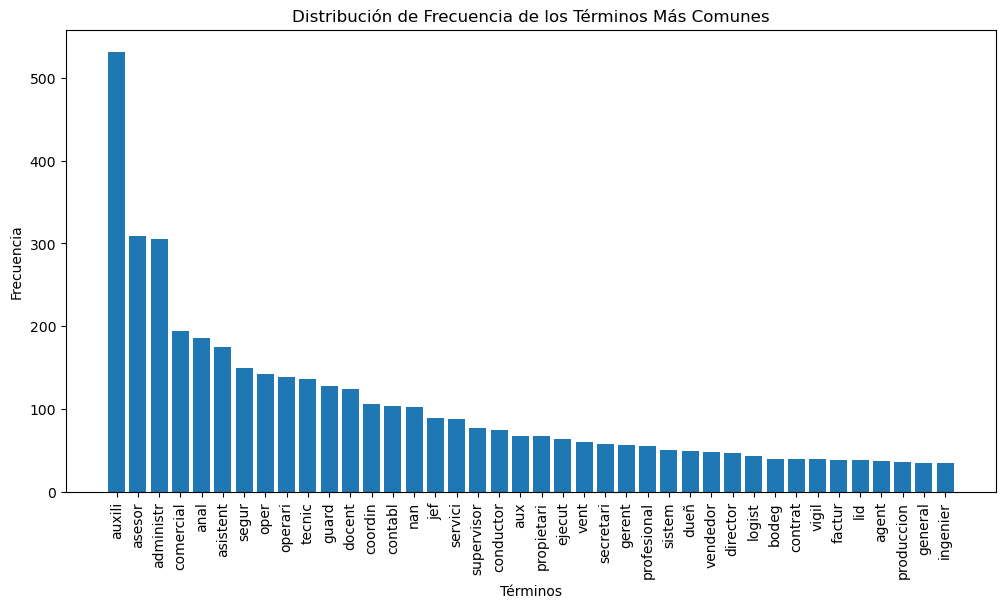

In [29]:
import matplotlib.pyplot as plt

# Obtener los términos y sus frecuencias de los términos más comunes
most_common_terms = fdist.most_common(40)  # Cambia 10 por el número de términos más comunes que deseas graficar
terms = [term[0] for term in most_common_terms]
freqs = [term[1] for term in most_common_terms]

# Graficar la distribución de frecuencia en un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(terms, freqs)
plt.xlabel('Términos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de los Términos Más Comunes')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mejor visualización
plt.show()


In [30]:
def token_mas_frecuente(texto, fdist):
    tokens = nltk.word_tokenize(texto)
    frecuencias = [(token, fdist[token]) for token in tokens if token in fdist]
    if frecuencias:
        return max(frecuencias, key=lambda x: x[1])[0]
    else:
        return None

In [31]:
df['token mas frecuente'] = df['Trabajo1'].apply(lambda x: token_mas_frecuente(x, fdist))

In [32]:
df[['TRABAJO','Trabajo1','token mas frecuente']].head(50)

,TRABAJO,Trabajo1,token mas frecuente
0,despachador de bodega,despach bodeg,bodeg
1,supervisor,supervisor,supervisor
2,Psicologa,psicolog,psicolog
3,rentista capital,rentist capital,rentist
4,Docente primera infancia,docent infanci,docent
5,Operador de divisas,oper divis,oper
6,jefe,jef,jef
7,ensamblador,ensambl,ensambl
8,TECNICO,tecnic,tecnic
9,nan,nan,nan


In [33]:
df['token mas frecuente'].nunique()

376

In [34]:
df['token mas frecuente'].value_counts().head(30)

token mas frecuente
auxili         532
asesor         309
administr      189
anal           174
operari        139
segur          139
docent         123
asistent       112
oper           110
tecnic         110
nan            102
coordin         95
jef             78
conductor       70
supervisor      67
propietari      64
comercial       61
profesional     54
gerent          49
dueñ            49
aux             47
secretari       46
vendedor        45
servici         41
ejecut          40
vigil           37
contador        32
cajer           30
agent           29
contrat         28
Name: count, dtype: int64

In [222]:
procesing_text('operario')

'operari'

In [155]:
len(embeddings_list)

4113

In [122]:
emb.vector.shape

(300,)

In [125]:
reY= nlp.vocab['reY'].vector
hombre = nlp.vocab['hombre'].vector
mujer = nlp.vocab['mujer'].vector

resultado = reY - hombre + mujer


## One hot encoding


In [7]:
df.columns

Index(['PLAZO', 'CAPITAL', 'DÍAS MORA', 'Cuotas en mora', 'ESTRATO',
       'INGRESOS MENSUALES', 'GASTOS MENSUALES', 'INGRESOS ADICIONALES',
       'PERSONAS A CARGO', 'NUMERO DE HIJOS', 'NUM.CREDITOS SOLICITADOS',
       'out', 'TIPO EMPLEO', 'CIUDAD RESIDENCIA', 'TRABAJO',
       'TIPO DE VIVIENDA', 'AÑOS EN LA VIVIENDA', 'TIPO DE CONTRATO',
       'PERIODO DE PAGO', 'ESTADO CIVIL', 'NIVEL EDUCATIVO',
       'TIPO DE VEHICULO', 'TIEMPO TRABAJO'],
      dtype='object')

In [5]:
df['AÑOS EN LA VIVIENDA'].unique()

array(['mas de 5 años', 'entre uno y cinco años', 'menos de un año', nan],
      dtype=object)

In [8]:
df['TIPO EMPLEO'].unique()

array(['Empleado', 'Independiente', 'Desempleado', 'Pensionado',
       'Prestador de servicios'], dtype=object)

In [9]:
df['TIPO DE VIVIENDA'].unique()

array([nan, 'Familiar', 'Arrendada', 'Propia', 'propia', 'arrendada'],
      dtype=object)

In [10]:
df['TIPO DE CONTRATO'].unique()

array(['Indefinido', 'Termino fijo', nan, 'Prestación de servicios'],
      dtype=object)

In [11]:
df['TIEMPO TRABAJO'].unique()

array(['24 meses', '12 meses', '1 año', ..., '2020-02-09', '2004-10-20',
       '2005-07-16'], dtype=object)

In [12]:
df['NIVEL EDUCATIVO'].unique()

array([nan, 'Profesional', 'Técnico', 'No tengo', 'Tecnólogo',
       'Secundaria', 'Postgrado', 'Primaria'], dtype=object)

In [164]:
import numpy as np
no_tiempo = df['TIEMPO TRABAJO'].apply(lambda x: not isinstance(x, str) or not re.match(r'\d{4}[-/]\d{2}[-/]\d{2}|[a-zA-Z]', x))
df.loc[no_tiempo, 'TIEMPO TRABAJO'] = np.nan
# Separar datos con letras y números
letras_numeros = df['TIEMPO TRABAJO'].str.contains(r'[a-zA-Z]', regex=True)
letras_numeros = letras_numeros.fillna(False)  # Rellenar NaN con False
df['letras_numeros'] = df['TIEMPO TRABAJO'][letras_numeros]
df['TIEMPO TRABAJO'] = df['TIEMPO TRABAJO'][~letras_numeros]

C:\Users\jgome\AppData\Local\Temp\ipykernel_32180\837928759.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  letras_numeros = letras_numeros.fillna(False)  # Rellenar NaN con False


In [166]:
df['TIEMPO TRABAJO'].nunique()

1419

In [167]:
df['letras_numeros'].unique()

array([nan, 'mas de 3 años', 'UN AÑO', 'Tres años', 'indefinido',
       'dos años', 'mas de 2 años', 'cuatro años y medio', 'DOS AÑOS',
       'indefinifa', 'COMPLETO', 'MAS DE 1 AÑO', 'marzo 1 de 2019',
       'Mayo 15 2018', 'tres años', 'Un mes', 'todo el dia', 'Mañana',
       'Seis meses', 'año y medio', 'más de tres años', 'Un año',
       'fredy enrique quiroz cel 3223596241 amigoyasmeli lopez cel 3232029436 ',
       'Un año temporal y 4 meses fija', 'Año y nueve meses', 'Completo',
       'cuatro años', 'Vinculado', 'Cooperativa', 'cinco años',
       'indefinida', 'SEIS HORAS', 'ext 102', 'ENTRE 07AM A 5PM',
       'Un Año',
       'Hora cátedra en la modalidad de pregrado y extensión a la comunidad universitaria así como a particulares a través de los cursos de extensión',
       'Horario de of', 'mas de 1 año', 'Tres años y dos meses',
       'mas de 6 meses a un año', 'Agosto 20 2000', 'COMERCIAL',
       'Dos años', 'Sed caquetá', 'Noviembre 19 2018', 'Tres meses',
     

In [65]:
def obtener_valor_numerico(texto):
    if isinstance(texto, str):
        if 'mes' in texto:
            match = re.search(r'\d+', texto)
            return int(match.group()) if match else None
        elif any(word in texto.lower() for word in ['años', 'anos', 'año', 'años', 'ano']):
            match = re.search(r'\d+', texto)
            numero = int(match.group()) if match else None
            return numero * 12 if numero else None
    return None

df['valor_numerico'] = df['letras_numeros'].apply(obtener_valor_numerico)

In [74]:
def obtener_valor_numerico(texto):
    if isinstance(texto, str):
        total_meses = 0
        total_anios = 0
        if 'mes' in texto:
            meses = re.findall(r'(\d+)\s*mes(es)?', texto)
            total_meses = sum(int(mes[0]) for mes in meses) if meses else 0
        if any(word in texto.lower() for word in ['años', 'anos', 'año', 'años', 'ano']):
            anios = re.findall(r'(\d+)\s*(años?|año)', texto)
            total_anios = sum(int(anio[0]) for anio in anios) if anios else 0
        return total_meses + total_anios
    return None

In [80]:
def reemplazar_numeros(texto):
    if isinstance(texto, str):
        numeros = {
            'un': '1', 'uno': '1',
            'dos': '2',
            'tres': '3',
            'cuatro': '4',
            'cinco': '5',
            'seis': '6',
            'siete': '7',
            'ocho': '8',
            'nueve': '9',
            'diez': '10'
        }
        palabras = texto.split()
        for i, palabra in enumerate(palabras):
            if palabra.lower() in numeros:
                palabras[i] = numeros[palabra.lower()]
        return ' '.join(palabras)
    return texto

In [144]:
def obtener_valor_numerico(texto):
    if texto is not None:
        texto = str(texto)
        texto = texto.lower()
        meses = 0
        anios = 0
        if 'mes' in texto:
            meses = re.findall(r'(\d+)\s*(?:mes?|meses?)', texto)
            if len(meses)==0:
                meses = 1
            else:    
                meses = int(meses[0])
                
        if any(word in texto.lower() for word in ['años', 'anos', 'año', 'años', 'ano']):
            anios = re.findall(r'(\d+)\s*(?:años?|anos?|año)', texto)
            if len(anios)==0:
                anios = 12
            else:    
                anios = 12*int(anios[0])
            #total_anios = sum(int(anio[0]) if anio[0] else 12 for anio in anios) if anios else 0
            #anios = re.findall(r'(\d+)\s*(años?|año)', texto)
            #total_anios = sum(int(anio[0]) for anio in anios) if anios else 0
            #if 'años' in texto.lower():
                #total_anios *= 12
        return meses + anios
    return None

texto = 'ano y 2 meses'
obtener_valor_numerico(texto)


14

In [145]:
df['letras_numeros'] = df['letras_numeros'].apply(reemplazar_numeros)
df['valor_numerico'] = df['letras_numeros'].apply(obtener_valor_numerico)

In [146]:
df[['letras_numeros','valor_numerico']].dropna().head(30)

,letras_numeros,valor_numerico
22,mas de 3 años,36
68,1 AÑO,12
91,3 años,36
111,indefinido,0
127,2 años,24
131,mas de 2 años,24
140,4 años y medio,48
152,indefinido,0
159,2 AÑOS,24
178,indefinifa,0


## estandarizacion con fuzzy


In [47]:
from fuzzywuzzy import fuzz

# Ejemplo de nombres de ciudades escritos de forma ligeramente diferente
from fuzzywuzzy import fuzz

# Lista de ciudades
ciudades = ["MEdellin", "Medellín", 'MED',"medekin","Buenos Aires", "Buenos Air", "Buenos Aire"]

# Diccionario para mapear nombres similares a un nombre estándar
mapeo = {}

for ciudad in ciudades:
    ciudad_estandar = None
    # Buscar si la ciudad ya está en el diccionario
    for ciudad_mapeada in mapeo:
        if fuzz.ratio(ciudad.lower(), ciudad_mapeada.lower()) > 60:  # Umbral de similitud del 80%
            ciudad_estandar = ciudad_mapeada
            break
    if ciudad_estandar:
        mapeo[ciudad_estandar].append(ciudad)
    else:
        mapeo[ciudad] = [ciudad]

# Mostrar el resultado del mapeo
for ciudad_estandar, variantes in mapeo.items():
    print(f"{ciudad_estandar}: {', '.join(variantes)}")


MEdellin: MEdellin, Medellín, medekin
MED: MED
Buenos Aires: Buenos Aires, Buenos Air, Buenos Aire


In [55]:
mapeo = {}

for ciudad in df['CIUDAD RESIDENCIA']:
    if isinstance(ciudad, str):  # Verificar si es un string
        ciudad_estandar = None
        # Buscar si la ciudad ya está en el diccionario
        for ciudad_mapeada in mapeo:
            if fuzz.ratio(ciudad.lower(), ciudad_mapeada.lower()) > 70:  # Umbral de similitud del 80%
                ciudad_estandar = ciudad_mapeada
                break
        if ciudad_estandar:
            mapeo[ciudad_estandar].append(ciudad)
        else:
            mapeo[ciudad] = [ciudad]

# Crear una nueva columna en el DataFrame con la ciudad estandarizada
def obtener_ciudad_estandar(ciudad):
    for ciudad_estandar, variantes in mapeo.items():
        if ciudad in variantes:
            return ciudad_estandar
    return ciudad

df['ciudad_estandarizada'] = df['CIUDAD RESIDENCIA'].apply(obtener_ciudad_estandar)

In [57]:
df['ciudad_estandarizada'].nunique()

294

In [56]:
df['CIUDAD RESIDENCIA'].nunique()

726

In [62]:
df['ciudad_estandarizada'].unique()

array(['pasto', 'buga', 'Cucuta', 'bogota', 'La Ceja', 'campoalegre',
       'medellin', 'pereira', 'Cartagena', 'Garzon', 'tolima',
       'Villanueva la guajira', 'Bello', 'envigado', 'BARRANQUILLA',
       'el carmen de bolivar', 'Leticia', 'san pedro de los milagros',
       'ibague', 'cali', 'Santa Marta', 'BUENAVENTURA', 'Soacha',
       'Manizales', 'VALLEDUPAR', 'dosquebradas', 'Rionegro',
       'Cundinamarca', 'venecia', 'BUCARAMANGA', 'San agustin', 'palmira',
       'madrid', 'Betania', 'Santo Tomas', 'Yopal', 'CHIGORODO',
       'soledad', 'Agustin codazzi', 'puerto boyaca', 'TABIO', 'duitama',
       'Fusagasuga', 'Tulua', 'Puerto tejada', 'BOGOTÁ, D.C.', 'Itagui',
       'monteria', 'Yarumal', 'valparaiso', 'planeta rica cordoba',
       'girardota', 'Fuente de oro', 'amaga(ant)', 'Florida',
       'La Tebaida', 'calarca', 'Floridablanca', 'Cunday-Tolima',
       'SAN ANDRES ISLAS', 'granada ', 'segovia', 'fundacion-magdalena',
       'SINCELEJO', 'Tumaco', 'Saldaña Toli

In [54]:
df[['CIUDAD RESIDENCIA','ciudad_estandarizada']].head(30)

,CIUDAD RESIDENCIA,ciudad_estandarizada
0,pasto,pasto
1,buga,buga
2,Cucuta,Cucuta
3,bogota,bogota
4,La Ceja,La Ceja
5,Cúcuta,Cucuta
6,campoalegre,campoalegre
7,medellin,medellin
8,pereira,pereira
9,bogota,bogota


In [151]:
import locale
import pandas as pd

# Establecer la configuración local a español
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

# Ejemplo de DataFrame con fechas en diferentes formatos
data = {'fechas': ['Mayo 15 2018', 'marzo 1 de 2019']}
df = pd.DataFrame(data)

# Convertir las fechas a formato datetime
df['fechas'] = df['fechas'].str.replace(' de ', ' ').str.capitalize()  # Eliminar 'de' y capitalizar el mes
df['fechas'] = pd.to_datetime(df['fechas'], format='%B %d %Y')  # Convertir a datetime

print(df)


      fechas
0 2018-05-15
1 2019-03-01


In [162]:
import pandas as pd

# Ejemplo de DataFrame con fechas en diferentes formatos
data = {'fechas': ['Mayo 15 2018', 'marzo 1 de 2019', '2018-08-31', '2007/04/25']}
df = pd.DataFrame(data)

# Convertir las fechas a formato datetime
df['fechas'] = df['fechas'].str.replace(' de ', ' ').str.capitalize()  # Eliminar 'de' y capitalizar el mes
df['fechas'] = pd.to_datetime(df['fechas'], format='%B %d %Y')  # Convertir a datetime

# Revertir las fechas al formato original
#df['fechas'] = df['fechas'].dt.strftime('%Y-%m-%d')  # Convertir a formato original

print(df)


ValueError: time data "2018-08-31" doesn't match format "%B %d %Y", at position 2. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [199]:
def es_fecha(texto):
    if pd.isna(texto):
        return None
    meses = r'(Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre)'
    patron = rf'({meses} \d{{1,2}} de \d{{4}}|{meses} \d{{1,2}} \d{{4}}|{meses} – \d{{1,2}} – \d{{4}}|{meses}\d{{1,2}}-\d{{4}})'
    match = re.search(patron, texto)
    if match:
        return match.group()

# Crear una nueva columna para las fechas
df['fechas'] = df['letras_numeros'].apply(es_fecha)

df['fechas'].dropna().head(30)

315           Mayo 15 2018
2901        Agosto 20 2000
3206     Noviembre 19 2018
3727           Julio2-2015
3993    Febrero – 6 – 2020
Name: fechas, dtype: object

In [198]:
def limpiar_texto(texto):
    if texto is None:
        return None
    # Eliminar caracteres especiales
    texto_limpio = re.sub(r'[^a-zA-Z0-9\s]', ' ', texto)
    # Eliminar espacios extra
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio)
    return texto_limpio.strip()

limpiar_texto('Julio2-2015')

'Julio2 2015'

In [211]:
def corregir_fecha(fecha):
    if pd.isna(fecha):
        return None
    meses = r'(Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre)'
    patron = rf'({meses}\s*\d{{1,2}}\s*\d{{4}}|{meses}\s*\d{{1,2}}-\d{{4}}|{meses}\d{{1,2}}-\d{{4}}|{meses}\s*–\s*\d{{1,2}}\s*–\s*\d{{4}})'
    match = re.search(patron, fecha)
    if match:
        fecha_corregida = match.group()
        fecha_corregida = re.sub(r'\s*-\s*', ' ', fecha_corregida)  # Eliminar guiones y espacios adicionales
        fecha_corregida = re.sub(r'(\D)(\d{1,2})(\D)', r'\1 \2\3', fecha_corregida)  # Agregar espacio antes del número del mes
        return fecha_corregida
    else:
        return fecha

# Aplicar la función al DataFrame
df['fechas'] = df['fechas'].apply(limpiar_texto)
df['fechas_corregidas'] = df['fechas'].apply(corregir_fecha)

df['fechas_corregidas'].dropna().head(30)


315          Mayo  15 2018
2901       Agosto  20 2000
3206    Noviembre  19 2018
3727          Julio 2 2015
3993       Febrero  6 2020
Name: fechas_corregidas, dtype: object

In [214]:
df['fechas_corregidas'] = pd.to_datetime(df['fechas_corregidas'], format='%B %d %Y') 

In [215]:
df['fechas_corregidas'].dropna().head(30)

315    2018-05-15
2901   2000-08-20
3206   2018-11-19
3727   2015-07-02
3993   2020-02-06
Name: fechas_corregidas, dtype: datetime64[ns]

In [217]:
df['TIEMPO TRABAJO'].unique()

array([nan, '2018-01-15', '2021-03-01', ..., '2020-02-09', '2004-10-20',
       '2005-07-16'], dtype=object)

In [219]:
df['TIEMPO TRABAJO'] = df['TIEMPO TRABAJO'].str.replace('/', '-')

# Convertir las fechas al formato "%Y-%m-%d"
df['TIEMPO TRABAJO'] = pd.to_datetime(df['TIEMPO TRABAJO'], errors='coerce', format='%Y-%m-%d')

In [222]:
df['TIEMPO TRABAJO'].dropna().head()

19   2018-01-15
51   2021-03-01
53   2020-02-04
76   2019-05-27
77   2019-07-23
Name: TIEMPO TRABAJO, dtype: datetime64[ns]

In [173]:
df['letras_numeros'].unique()

array([nan, 'mas de 3 años', 'UN AÑO', 'Tres años', 'indefinido',
       'dos años', 'mas de 2 años', 'cuatro años y medio', 'DOS AÑOS',
       'indefinifa', 'COMPLETO', 'MAS DE 1 AÑO', 'marzo 1 de 2019',
       'Mayo 15 2018', 'tres años', 'Un mes', 'todo el dia', 'Mañana',
       'Seis meses', 'año y medio', 'más de tres años', 'Un año',
       'fredy enrique quiroz cel 3223596241 amigoyasmeli lopez cel 3232029436 ',
       'Un año temporal y 4 meses fija', 'Año y nueve meses', 'Completo',
       'cuatro años', 'Vinculado', 'Cooperativa', 'cinco años',
       'indefinida', 'SEIS HORAS', 'ext 102', 'ENTRE 07AM A 5PM',
       'Un Año',
       'Hora cátedra en la modalidad de pregrado y extensión a la comunidad universitaria así como a particulares a través de los cursos de extensión',
       'Horario de of', 'mas de 1 año', 'Tres años y dos meses',
       'mas de 6 meses a un año', 'Agosto 20 2000', 'COMERCIAL',
       'Dos años', 'Sed caquetá', 'Noviembre 19 2018', 'Tres meses',
     